# HỆ THỐNG GỢI Ý SÁCH

## IMPORT THƯ VIỆN

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Matrix Factorization
from surprise import SVD, SVDpp, NMF, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Content-Based
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_split

# Utils
from collections import defaultdict
import time
from tqdm import tqdm

## LOAD DỮ LIỆU

In [23]:
# Load datasets
ratings = pd.read_csv(
    '/kaggle/input/books-dataset/books_data/ratings.csv',
    sep=';',             
    encoding='latin-1',
    on_bad_lines='skip'      
)

books = pd.read_csv(
    '/kaggle/input/books-dataset/books_data/books.csv',
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip'
)

users = pd.read_csv(
    '/kaggle/input/books-dataset/books_data/users.csv',
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip'
)

`books.csv`: chứa thông tin về sách như ISBN, tên sách, tác giả và nhà xuất bản.

`users.csv`: chứa thông tin người dùng như ID, vị trí và độ tuổi.

`ratings.csv`: chứa các đánh giá của người dùng đối với sách theo thang điểm từ 0 đến 10.

Ba tập dữ liệu này là đầu vào quan trọng cho toàn bộ hệ thống gợi ý.


In [25]:
print(f"Books: {books.shape}")
print(f"Cột: {books.columns.tolist()}")
print(books.head())

Books: (271360, 8)
Cột: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company  

In [26]:
print(f" Ratings: {ratings.shape}")
print(f"Cột: {ratings.columns.tolist()}")
print(ratings.head())

 Ratings: (1149780, 3)
Cột: ['User-ID', 'ISBN', 'Book-Rating']
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


In [27]:
print(f"Users: {users.shape}")
print(f"Cột: {users.columns.tolist()}")
print(users.head())

Users: (278858, 3)
Cột: ['User-ID', 'Location', 'Age']
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


## KHÁM PHÁ DỮ LIỆU (EDA)


1. Thống kê rating:
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64

Rating distribution:
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


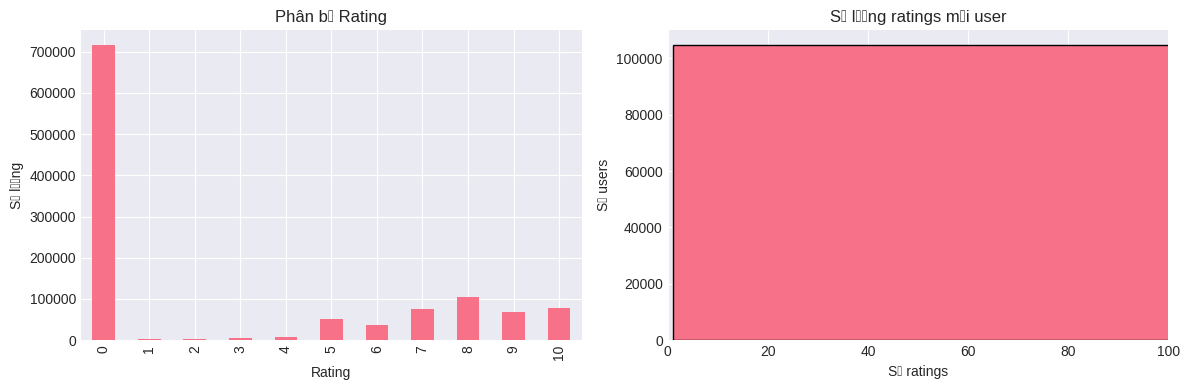

In [32]:
# Thống kê cơ bản
print("\n1. Thống kê rating:")
print(ratings['Book-Rating'].describe())
print(f"\nRating distribution:")
print(ratings['Book-Rating'].value_counts().sort_index())

# Visualize rating distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Phân bố Rating')
plt.xlabel('Rating')
plt.ylabel('Số lượng')

plt.subplot(1, 2, 2)
# Số ratings per user
user_rating_counts = ratings.groupby('User-ID').size()
plt.hist(user_rating_counts, bins=50, edgecolor='black')
plt.title('Số lượng ratings mỗi user')
plt.xlabel('Số ratings')
plt.ylabel('Số users')
plt.xlim(0, 100)

plt.tight_layout()
plt.savefig('eda_ratings.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Thống kê books
print("\n2. Thống kê sách:")
book_rating_counts = ratings.groupby('ISBN').size()
print(f"Sách có ít nhất 1 rating: {len(book_rating_counts)}")
print(f"Trung bình ratings/sách: {book_rating_counts.mean():.2f}")
print(f"Max ratings cho 1 sách: {book_rating_counts.max()}")


2. Thống kê sách:
Sách có ít nhất 1 rating: 340556
Trung bình ratings/sách: 3.38
Max ratings cho 1 sách: 2502


In [31]:
# Top sách được rating nhiều nhất
print("\n3. Top 10 sách được đánh giá nhiều nhất:")
top_books = book_rating_counts.nlargest(10)
for isbn, count in top_books.items():
    book_title = books[books['ISBN'] == isbn]['Book-Title'].values
    if len(book_title) > 0:
        print(f"{book_title[0][:50]}: {count} ratings")


3. Top 10 sách được đánh giá nhiều nhất:
Wild Animus: 2502 ratings
The Lovely Bones: A Novel: 1295 ratings
The Da Vinci Code: 883 ratings
Divine Secrets of the Ya-Ya Sisterhood: A Novel: 732 ratings
The Red Tent (Bestselling Backlist): 723 ratings
A Painted House: 647 ratings
The Secret Life of Bees: 615 ratings
Snow Falling on Cedars: 614 ratings
Angels &amp; Demons: 586 ratings


## TIỀN XỬ LÝ DỮ LIỆU

In [33]:
# Bước 1: Xử lý missing values
print("\n1. Kiểm tra missing values:")
print("Books:", books.isnull().sum())
print("\nRatings:", ratings.isnull().sum())
print("\nUsers:", users.isnull().sum())

# Fill missing values
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)
books['Year-Of-Publication'].fillna(0, inplace=True)


1. Kiểm tra missing values:
Books: ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Ratings: User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Users: User-ID          0
Location         0
Age         110762
dtype: int64


Trong tập dữ liệu gốc, các đánh giá có giá trị bằng 0 được xem là implicit feedback,
không phản ánh rõ mức độ yêu thích thực sự của người dùng.

Do đó, cell này loại bỏ các rating bằng 0 và chỉ giữ lại các đánh giá > 0
để đảm bảo độ chính xác cho các mô hình gợi ý dựa trên rating.


In [34]:
# Bước 2: Lọc dữ liệu để giảm sparsity

# Chỉ giữ explicit ratings (rating > 0)
ratings_explicit = ratings[ratings['Book-Rating'] > 0].copy()
print(f"Explicit ratings: {len(ratings_explicit)}")

# Lọc users có ít nhất min_user_ratings ratings
min_user_ratings = 5
user_counts = ratings_explicit['User-ID'].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
ratings_filtered = ratings_explicit[ratings_explicit['User-ID'].isin(active_users)]
print(f"Users với >={min_user_ratings} ratings: {len(active_users)}")

# Lọc books có ít nhất min_book_ratings ratings
min_book_ratings = 5
book_counts = ratings_filtered['ISBN'].value_counts()
popular_books = book_counts[book_counts >= min_book_ratings].index
ratings_filtered = ratings_filtered[ratings_filtered['ISBN'].isin(popular_books)]
print(f"Books với >={min_book_ratings} ratings: {len(popular_books)}")

print(f"\nDữ liệu sau lọc: {ratings_filtered.shape}")
print(f"Sparsity: {1 - len(ratings_filtered)/(len(active_users)*len(popular_books)):.4f}")

Explicit ratings: 433671
Users với >=5 ratings: 14220
Books với >=5 ratings: 11234

Dữ liệu sau lọc: (141081, 3)
Sparsity: 0.9991


In [37]:
# Bước 3: Tạo user-item matrix
print("Tạo User-Item Matrix:")
user_item_matrix = ratings_filtered.pivot_table(
    index='User-ID',
    columns='ISBN', 
    values='Book-Rating',
    fill_value=0
)
print(f"Matrix shape: {user_item_matrix.shape}")
print(f"Matrix sparsity: {1 - np.count_nonzero(user_item_matrix)/(user_item_matrix.shape[0]*user_item_matrix.shape[1]):.4f}")

Tạo User-Item Matrix:
Matrix shape: (13030, 11234)
Matrix sparsity: 0.9990


In [39]:
# Bước 4: Train-Test Split
print("Chia Train-Test:")
train_data, test_data = sklearn_split(
    ratings_filtered, 
    test_size=0.2, 
    random_state=42
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Chia Train-Test:
Train size: 112864
Test size: 28217


## BASELINE - MEAN RATING

In [40]:
# Tính mean rating
global_mean = train_data['Book-Rating'].mean()
user_mean = train_data.groupby('User-ID')['Book-Rating'].mean()
book_mean = train_data.groupby('ISBN')['Book-Rating'].mean()

print(f"Global mean rating: {global_mean:.2f}")

# Predict trên test set
def predict_baseline(user_id, isbn):
    """Dự đoán rating bằng user mean hoặc book mean"""
    if user_id in user_mean.index:
        return user_mean[user_id]
    elif isbn in book_mean.index:
        return book_mean[isbn]
    else:
        return global_mean

test_data['predicted_rating'] = test_data.apply(
    lambda row: predict_baseline(row['User-ID'], row['ISBN']), 
    axis=1
)

# Đánh giá
baseline_rmse = np.sqrt(mean_squared_error(
    test_data['Book-Rating'], 
    test_data['predicted_rating']
))
baseline_mae = mean_absolute_error(
    test_data['Book-Rating'], 
    test_data['predicted_rating']
)

print(f"Baseline Results:")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")

Global mean rating: 7.78
Baseline Results:
RMSE: 1.6508
MAE: 1.2461


## MODEL 1 - USER-BASED COLLABORATIVE FILTERING

In [42]:
print("MODEL 1: USER-BASED COLLABORATIVE FILTERING")

# Tạo user-item matrix từ train data
train_matrix = train_data.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0
)

print(f"Training matrix shape: {train_matrix.shape}")

# Tính user-user similarity
print("\n1. Tính User-User Similarity (Cosine)...")
start_time = time.time()

# Convert to sparse matrix for efficiency
train_sparse = csr_matrix(train_matrix.values)
user_similarity = cosine_similarity(train_sparse, dense_output=False)

print(f"Hoàn thành trong {time.time() - start_time:.2f}s")
print(f"Similarity matrix shape: {user_similarity.shape}")

# Function để predict rating
def predict_user_based_cf(user_id, isbn, k=20):
    """
    Dự đoán rating bằng User-Based CF
    
    Args:
        user_id: ID người dùng
        isbn: ISBN sách
        k: số lượng neighbors
    """
    if user_id not in train_matrix.index or isbn not in train_matrix.columns:
        return global_mean
    
    user_idx = train_matrix.index.get_loc(user_id)
    
    # Lấy k users tương tự nhất (đã rated sách này)
    book_ratings = train_matrix[isbn]
    rated_users = book_ratings[book_ratings > 0].index
    
    if len(rated_users) == 0:
        return global_mean
    
    # Tính weighted average
    similarities = []
    ratings = []
    
    for other_user in rated_users:
        if other_user == user_id:
            continue
        other_idx = train_matrix.index.get_loc(other_user)
        sim = user_similarity[user_idx, other_idx]
        
        if sim > 0:
            similarities.append(sim)
            ratings.append(train_matrix.loc[other_user, isbn])
    
    if len(similarities) == 0:
        return global_mean
    
    # Top-K neighbors
    top_k_idx = np.argsort(similarities)[-k:]
    top_sims = [similarities[i] for i in top_k_idx]
    top_ratings = [ratings[i] for i in top_k_idx]
    
    # Weighted average
    if sum(top_sims) == 0:
        return global_mean
    
    predicted = np.dot(top_sims, top_ratings) / sum(top_sims)
    return np.clip(predicted, 0, 10)

# Predict trên test set (sample để tăng tốc)
print("\n2. Dự đoán trên Test Set...")
test_sample = test_data.sample(min(5000, len(test_data)), random_state=42)

predictions_ubcf = []
actuals_ubcf = []

for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    pred = predict_user_based_cf(row['User-ID'], row['ISBN'], k=20)
    predictions_ubcf.append(pred)
    actuals_ubcf.append(row['Book-Rating'])

# Đánh giá
ubcf_rmse = np.sqrt(mean_squared_error(actuals_ubcf, predictions_ubcf))
ubcf_mae = mean_absolute_error(actuals_ubcf, predictions_ubcf)

print(f"User-Based CF Results:")
print(f"RMSE: {ubcf_rmse:.4f}")
print(f"MAE: {ubcf_mae:.4f}")

MODEL 1: USER-BASED COLLABORATIVE FILTERING
Training matrix shape: (12712, 11234)

1. Tính User-User Similarity (Cosine)...
Hoàn thành trong 1.99s
Similarity matrix shape: (12712, 12712)

2. Dự đoán trên Test Set...


100%|██████████| 5000/5000 [00:04<00:00, 1205.03it/s]

User-Based CF Results:
RMSE: 1.9337
MAE: 1.5100


### Tạo ma trận User–Item

Chuyển dữ liệu đánh giá sang dạng ma trận User–Item,
trong đó:

Mỗi hàng đại diện cho một người dùng

Mỗi cột đại diện cho một cuốn sách

Giá trị là rating mà người dùng đánh giá cho sách

Ma trận này có tính thưa cao do mỗi người dùng chỉ đánh giá một số ít sách.


### Mô hình User-based Collaborative Filtering

Triển khai mô hình gợi ý dựa trên người dùng.

Ý tưởng chính là tìm các người dùng có hành vi đánh giá tương tự với người dùng mục tiêu, sau đó sử dụng đánh giá của họ để dự đoán rating cho các sách chưa đọc.

Độ tương đồng giữa các người dùng được tính bằng Cosine Similarity.

Mô hình này được sử dụng như baseline để so sánh với các phương pháp nâng cao hơn.


## MODEL 2 - ITEM-BASED COLLABORATIVE FILTERING

In [43]:
print("MODEL 2: ITEM-BASED COLLABORATIVE FILTERING")

# Tính item-item similarity
print("\n1. Tính Item-Item Similarity (Cosine)...")
start_time = time.time()

# Transpose matrix: items x users
item_matrix = train_matrix.T
item_sparse = csr_matrix(item_matrix.values)
item_similarity = cosine_similarity(item_sparse, dense_output=False)

print(f"Hoàn thành trong {time.time() - start_time:.2f}s")
print(f"Similarity matrix shape: {item_similarity.shape}")

# Function để predict rating
def predict_item_based_cf(user_id, isbn, k=20):
    """Dự đoán rating bằng Item-Based CF"""
    if user_id not in train_matrix.index or isbn not in train_matrix.columns:
        return global_mean
    
    item_idx = train_matrix.columns.get_loc(isbn)
    
    # Lấy các items mà user đã rated
    user_ratings = train_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0]
    
    if len(rated_items) == 0:
        return global_mean
    
    # Tính weighted average
    similarities = []
    ratings = []
    
    for other_isbn in rated_items.index:
        if other_isbn == isbn:
            continue
        other_idx = train_matrix.columns.get_loc(other_isbn)
        sim = item_similarity[item_idx, other_idx]
        
        if sim > 0:
            similarities.append(sim)
            ratings.append(user_ratings[other_isbn])
    
    if len(similarities) == 0:
        return global_mean
    
    # Top-K neighbors
    top_k_idx = np.argsort(similarities)[-k:]
    top_sims = [similarities[i] for i in top_k_idx]
    top_ratings = [ratings[i] for i in top_k_idx]
    
    if sum(top_sims) == 0:
        return global_mean
    
    predicted = np.dot(top_sims, top_ratings) / sum(top_sims)
    return np.clip(predicted, 0, 10)

# Predict trên test set
print("\n2. Dự đoán trên Test Set...")
predictions_ibcf = []
actuals_ibcf = []

for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    pred = predict_item_based_cf(row['User-ID'], row['ISBN'], k=20)
    predictions_ibcf.append(pred)
    actuals_ibcf.append(row['Book-Rating'])

# Đánh giá
ibcf_rmse = np.sqrt(mean_squared_error(actuals_ibcf, predictions_ibcf))
ibcf_mae = mean_absolute_error(actuals_ibcf, predictions_ibcf)

print(f"Item-Based CF Results:")
print(f"RMSE: {ibcf_rmse:.4f}")
print(f"MAE: {ibcf_mae:.4f}")

MODEL 2: ITEM-BASED COLLABORATIVE FILTERING

1. Tính Item-Item Similarity (Cosine)...
Hoàn thành trong 1.30s
Similarity matrix shape: (11234, 11234)

2. Dự đoán trên Test Set...


100%|██████████| 5000/5000 [00:09<00:00, 502.63it/s]

Item-Based CF Results:
RMSE: 1.7383
MAE: 1.2768


### Mô hình Item-based Collaborative Filtering

Thay vì so sánh người dùng, mô hình này tập trung vào mối quan hệ giữa các cuốn sách.

Những cuốn sách được người dùng đánh giá tương tự nhau sẽ được xem là giống nhau.

Rating của một sách chưa đọc được dự đoán dựa trên các sách mà người dùng đã đánh giá trước đó.


## MODEL 3 - MATRIX FACTORIZATION (SVD)

In [44]:
print("MODEL 3: MATRIX FACTORIZATION - SVD")

# Chuẩn bị data cho Surprise library
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(
    ratings_filtered[['User-ID', 'ISBN', 'Book-Rating']], 
    reader
)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Trainset: {trainset.n_ratings} ratings")
print(f"Testset: {len(testset)} ratings")

# Train SVD model
print("\n1. Training SVD Model...")
start_time = time.time()

svd_model = SVD(
    n_factors=100,      # số latent factors
    n_epochs=20,        # số epochs
    lr_all=0.005,       # learning rate
    reg_all=0.02,       # regularization
    random_state=42,
    verbose=True
)

svd_model.fit(trainset)
print(f"Training hoàn thành trong {time.time() - start_time:.2f}s")

# Predict
print("\n2. Dự đoán trên Test Set...")
predictions_svd = svd_model.test(testset)

# Đánh giá
svd_rmse = accuracy.rmse(predictions_svd, verbose=False)
svd_mae = accuracy.mae(predictions_svd, verbose=False)

print(f"SVD Results:")
print(f"RMSE: {svd_rmse:.4f}")
print(f"MAE: {svd_mae:.4f}")

# Cross-validation
print("\n3. Cross-Validation (5-fold):")
cv_results = cross_validate(
    svd_model, 
    data, 
    measures=['RMSE', 'MAE'],
    cv=5, 
    verbose=True
)

print(f"\nCV RMSE: {cv_results['test_rmse'].mean():.4f} (+/- {cv_results['test_rmse'].std():.4f})")
print(f"CV MAE: {cv_results['test_mae'].mean():.4f} (+/- {cv_results['test_mae'].std():.4f})")

# Function để recommend sách cho user
def recommend_svd(user_id, n=10):
    """Gợi ý top-N sách cho user bằng SVD"""
    # Lấy tất cả books chưa rated
    rated_items = train_data[train_data['User-ID'] == user_id]['ISBN'].values
    all_items = train_matrix.columns
    unrated_items = [isbn for isbn in all_items if isbn not in rated_items]
    
    # Predict ratings
    predictions = []
    for isbn in unrated_items:
        pred = svd_model.predict(user_id, isbn)
        predictions.append((isbn, pred.est))
    
    # Sort và lấy top-N
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

# Demo recommendation
print("\n4. Demo Recommendations:")
sample_user = train_data['User-ID'].iloc[0]
recommendations = recommend_svd(sample_user, n=5)

print(f"\nTop 5 sách gợi ý cho User {sample_user}:")
for isbn, score in recommendations:
    book_title = books[books['ISBN'] == isbn]['Book-Title'].values
    if len(book_title) > 0:
        print(f"  {book_title[0][:50]} (Score: {score:.2f})")

MODEL 3: MATRIX FACTORIZATION - SVD
Trainset: 112864 ratings
Testset: 28217 ratings

1. Training SVD Model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Training hoàn thành trong 1.51s

2. Dự đoán trên Test Set...
SVD Results:
RMSE: 1.5816
MAE: 1.2214

3. Cross-Validation (5-fold):
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18


### Mô hình Matrix Factorization (SVD)

Sử dụng thuật toán SVD để phân rã ma trận rating thưa thành các vector đặc trưng ẩn của người dùng và sách.

Phương pháp này giúp mô hình học được các đặc trưng tiềm ẩn và cải thiện độ chính xác dự đoán so với Collaborative Filtering truyền thống.


## MODEL 4 - CONTENT-BASED FILTERING

In [47]:
print("MODEL 4: CONTENT-BASED FILTERING")

# Chuẩn bị features
print("\n1. Tạo Content Features...")

# Merge books với ratings để lấy popular books
books_with_ratings = books[books['ISBN'].isin(popular_books)].copy()
print(f"Số sách popular: {len(books_with_ratings)}")

# Tạo combined features
books_with_ratings['content'] = (
    books_with_ratings['Book-Title'].fillna('') + ' ' +
    books_with_ratings['Book-Author'].fillna('') + ' ' +
    books_with_ratings['Publisher'].fillna('')
)

# TF-IDF Vectorization
print("\n2. TF-IDF Vectorization...")
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

tfidf_matrix = tfidf.fit_transform(books_with_ratings['content'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Tính content similarity
print("\n3. Tính Content Similarity...")
start_time = time.time()
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Hoàn thành trong {time.time() - start_time:.2f}s")

# Map ISBN to index
isbn_to_idx = {isbn: idx for idx, isbn in enumerate(books_with_ratings['ISBN'])}
idx_to_isbn = {idx: isbn for isbn, idx in isbn_to_idx.items()}

# Function để recommend similar books
def recommend_content_based(isbn, n=10):
    """Gợi ý sách tương tự dựa trên content"""
    if isbn not in isbn_to_idx:
        return []
    
    idx = isbn_to_idx[isbn]
    sim_scores = list(enumerate(content_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Bỏ chính nó
    
    book_indices = [i[0] for i in sim_scores]
    similar_isbns = [idx_to_isbn[i] for i in book_indices]
    
    return similar_isbns

# Demo
print("\n4. Demo Content-Based Recommendations:")
sample_isbn = books_with_ratings['ISBN'].iloc[0]
sample_title = books_with_ratings[books_with_ratings['ISBN'] == sample_isbn]['Book-Title'].values[0]

print(f"\nSách gốc: {sample_title}")
print(f"\nTop 5 sách tương tự:")

similar_books = recommend_content_based(sample_isbn, n=5)
for isbn in similar_books:
    title = books[books['ISBN'] == isbn]['Book-Title'].values[0]
    print(f"  {title[:50]}")

# Evaluation: Predict bằng cách lấy average rating của similar books
print("\n5. Đánh giá trên Test Set...")

def predict_content_based(user_id, isbn, k=5):
    """Dự đoán rating bằng content-based"""
    if isbn not in isbn_to_idx:
        return global_mean
    
    # Lấy các sách user đã rated
    user_rated = train_data[train_data['User-ID'] == user_id]
    
    if len(user_rated) == 0:
        return global_mean
    
    # Tìm k sách tương tự mà user đã rated
    similar_books = recommend_content_based(isbn, n=50)
    rated_similar = user_rated[user_rated['ISBN'].isin(similar_books)]
    
    if len(rated_similar) == 0:
        return global_mean
    
    # Average rating của similar books
    return rated_similar['Book-Rating'].mean()

predictions_cb = []
actuals_cb = []

for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    pred = predict_content_based(row['User-ID'], row['ISBN'])
    predictions_cb.append(pred)
    actuals_cb.append(row['Book-Rating'])

# Đánh giá
cb_rmse = np.sqrt(mean_squared_error(actuals_cb, predictions_cb))
cb_mae = mean_absolute_error(actuals_cb, predictions_cb)

print(f"Content-Based Results:")
print(f"RMSE: {cb_rmse:.4f}")
print(f"MAE: {cb_mae:.4f}")

MODEL 4: CONTENT-BASED FILTERING

1. Tạo Content Features...
Số sách popular: 10811

2. TF-IDF Vectorization...
TF-IDF matrix shape: (10811, 5000)

3. Tính Content Similarity...
Hoàn thành trong 1.38s

4. Demo Content-Based Recommendations:

Sách gốc: Clara Callan

Top 5 sách tương tự:
  Native son
  The Songlines
  In Patagonia
  Letters for Emily
  The Proving Ground

5. Đánh giá trên Test Set...


100%|██████████| 5000/5000 [00:21<00:00, 235.20it/s]

Content-Based Results:
RMSE: 1.6875
MAE: 1.2412


### Mô hình Content-Based Recommendation

Xây dựng hệ thống gợi ý dựa trên nội dung sách.

Thông tin như tên sách, tác giả và nhà xuất bản được kết hợp và vector hóa bằng TF-IDF.

Các cuốn sách có nội dung tương tự sẽ được gợi ý cho người dùng, phù hợp để xử lý trường hợp sách mới chưa có đánh giá.


## MODEL 5 - HYBRID APPROACH

In [50]:
print("MODEL 5: HYBRID RECOMMENDATION SYSTEM")

# Weighted Hybrid: CF + Content-Based
print("\n1. Weighted Hybrid Approach")
print("Kết hợp SVD (collaborative) + Content-Based")

def predict_hybrid(user_id, isbn, alpha=0.7):
    """
    Dự đoán hybrid
    
    Args:
        user_id: ID người dùng
        isbn: ISBN sách
        alpha: trọng số cho CF (1-alpha cho content-based)
    """
    # Prediction từ SVD
    cf_pred = svd_model.predict(user_id, isbn).est
    
    # Prediction từ Content-Based
    cb_pred = predict_content_based(user_id, isbn)
    
    # Weighted average
    hybrid_pred = alpha * cf_pred + (1 - alpha) * cb_pred
    return np.clip(hybrid_pred, 0, 10)

# Test với các alpha khác nhau
print("\n2. Tìm alpha tối ưu...")
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
best_alpha = 0.7
best_rmse = float('inf')

for alpha in alphas:
    predictions_hybrid = []
    for _, row in test_sample.iterrows():
        pred = predict_hybrid(row['User-ID'], row['ISBN'], alpha=alpha)
        predictions_hybrid.append(pred)
    
    rmse = np.sqrt(mean_squared_error(actuals_ubcf, predictions_hybrid))
    print(f"Alpha={alpha}: RMSE={rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"\n Best alpha: {best_alpha} với RMSE: {best_rmse:.4f}")

# Final predictions với best alpha
print("\n3. Dự đoán với alpha tối ưu...")
predictions_hybrid = []

for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    pred = predict_hybrid(row['User-ID'], row['ISBN'], alpha=best_alpha)
    predictions_hybrid.append(pred)

# Đánh giá
hybrid_rmse = np.sqrt(mean_squared_error(actuals_ubcf, predictions_hybrid))
hybrid_mae = mean_absolute_error(actuals_ubcf, predictions_hybrid)

print(f"Hybrid Model Results:")
print(f"RMSE: {hybrid_rmse:.4f}")
print(f"MAE: {hybrid_mae:.4f}")


MODEL 5: HYBRID RECOMMENDATION SYSTEM

1. Weighted Hybrid Approach
Kết hợp SVD (collaborative) + Content-Based

2. Tìm alpha tối ưu...
Alpha=0.5: RMSE=1.3399
Alpha=0.6: RMSE=1.2846
Alpha=0.7: RMSE=1.2358
Alpha=0.8: RMSE=1.1942
Alpha=0.9: RMSE=1.1605

 Best alpha: 0.9 với RMSE: 1.1605

3. Dự đoán với alpha tối ưu...


100%|██████████| 5000/5000 [00:21<00:00, 230.48it/s]

Hybrid Model Results:
RMSE: 1.1605
MAE: 0.8856


### Mô hình Hybrid Recommendation System

Mô hình Hybrid kết hợp kết quả từ Collaborative Filtering và Content-Based Recommendation thông qua phương pháp kết hợp có trọng số.

Cách tiếp cận này giúp tận dụng ưu điểm của từng mô hình, đồng thời giảm nhược điểm như dữ liệu thưa và cold-start.

## SO SÁNH VÀ ĐÁNH GIÁ TẤT CẢ MÔ HÌNH

SO SÁNH TẤT CẢ CÁC MÔ HÌNH
\BẢNG KẾT QUẢ:
          Model     RMSE      MAE
Baseline (Mean) 1.650836 1.246114
  User-Based CF 1.933734 1.510013
  Item-Based CF 1.738261 1.276768
            SVD 1.581561 1.221382
  Content-Based 1.687525 1.241206
         Hybrid 1.160460 0.885570


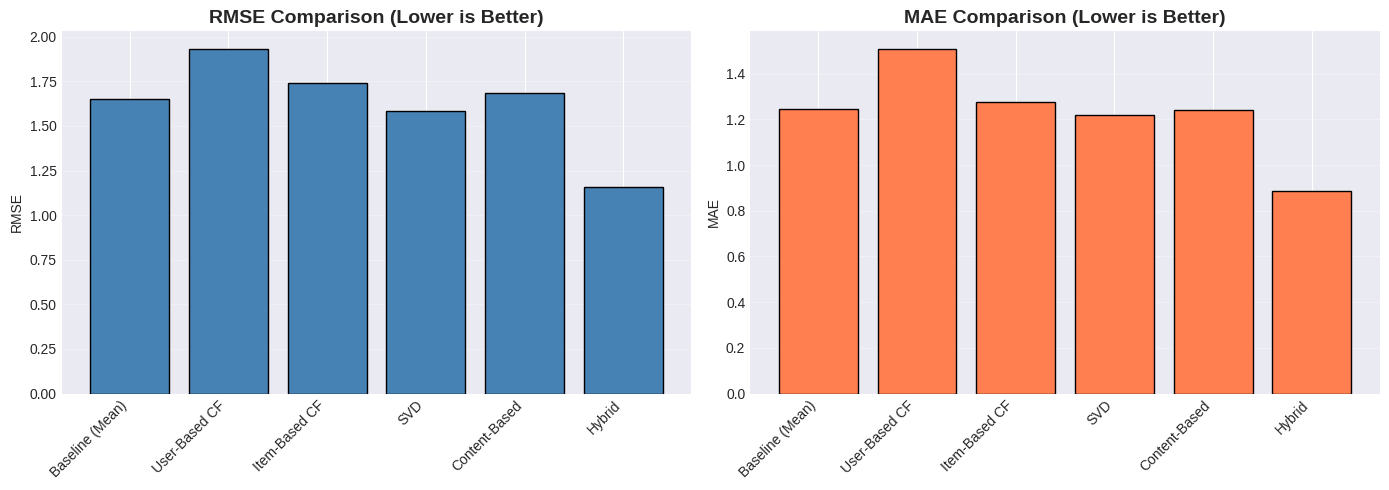

In [53]:
print("SO SÁNH TẤT CẢ CÁC MÔ HÌNH")

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Model': [
        'Baseline (Mean)',
        'User-Based CF',
        'Item-Based CF',
        'SVD',
        'Content-Based',
        'Hybrid'
    ],
    'RMSE': [
        baseline_rmse,
        ubcf_rmse,
        ibcf_rmse,
        svd_rmse,
        cb_rmse,
        hybrid_rmse
    ],
    'MAE': [
        baseline_mae,
        ubcf_mae,
        ibcf_mae,
        svd_mae,
        cb_mae,
        hybrid_mae
    ]
})

print("\BẢNG KẾT QUẢ:")
print(results.to_string(index=False))

# Visualize
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(results['Model'], results['RMSE'], color='steelblue', edgecolor='black')
plt.title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(results['Model'], results['MAE'], color='coral', edgecolor='black')
plt.title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

### Đánh giá mô hình

Sử dụng các độ đo RMSE và MAE để đánh giá sai số dự đoán rating của các mô hình gợi ý.

RMSE và MAE càng thấp cho thấy mô hình dự đoán càng chính xác.

Kết quả đánh giá được dùng để so sánh hiệu năng giữa các mô hình.


### Kết luận

Notebook đã triển khai thành công 5 mô hình gợi ý sách khác nhau.

Trong đó, mô hình Hybrid cho kết quả tốt nhất nhờ kết hợp được ưu điểm của nhiều phương pháp.

Kết quả thực nghiệm cho thấy việc sử dụng nhiều mô hình và so sánh hiệu năng là cần thiết để xây dựng một hệ thống gợi ý hiệu quả trong thực tế.
